In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint as sp_randint
from time import time
from sklearn.metrics import roc_curve, auc
from scipy import interp
from pylab import rcParams
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score

In [2]:
rcParams['figure.figsize'] = 12, 8

In [3]:
df = pd.read_csv('/home/alexshein/processed_pals/S10-20_L0-8_M5/AluFirstVSLast.csv', sep=';')
df = df[[i for i in list(df.columns) if i not in ('Unnamed: 0')]]
df = df.fillna(value=0.0)

In [4]:
df.describe()

,AA,AAA,AAC,AAG,AAT,AC,ACA,ACC,ACG,ACT,...,TGA,TGC,TGG,TGT,TT,TTA,TTC,TTG,TTT,is_target
count,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,...,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.000000,24858.00000
mean,0.065854,0.017701,0.012712,0.012471,0.012873,0.595181,0.042159,0.010298,0.002213,0.068147,...,0.009776,0.004908,0.019591,0.042481,0.237871,0.000684,0.226326,0.001569,0.002575,0.50000
std,0.313769,0.139858,0.113104,0.111339,0.126200,0.554156,0.202353,0.100960,0.046987,0.252163,...,0.098797,0.069886,0.138594,0.202087,0.427956,0.026143,0.418557,0.039579,0.050676,0.50001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,2.000000,...,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.00000


In [5]:
df[df['is_target']==1]['GC precentage'].describe()

count    12429.000000
mean        42.697300
std          9.640165
min          0.000000
25%         36.000000
50%         45.454545
75%         50.000000
max         68.000000
Name: GC precentage, dtype: float64

In [6]:
df[df['is_target']==0]['GC precentage'].describe()

count    12429.000000
mean        35.933599
std          2.956784
min         17.391304
25%         36.000000
50%         36.000000
75%         36.000000
max         54.545455
Name: GC precentage, dtype: float64

In [7]:
dfX = df[[i for i in list(df.columns) if i not in ('is_target')]]
dfY = df['is_target']

In [8]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=5)

In [9]:
def draw_roc_auc(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        probas_ = rf.fit(dfX.iloc[train], dfY.iloc[train]).predict_proba(dfX.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(
            fpr,
            tpr,
            lw=1,
            alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (k, roc_auc)
        )

    plt.plot(
        [0, 1],
        [0, 1],
        linestyle='--',
        lw=2,
        color='r',
        label='Luck',
        alpha=.8
    )
    fpr, tpr, thresholds = roc_curve(dfY.iloc[test], probas_[:, 1])

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.3f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color='grey',
        alpha=.2,
        label=r'$\pm$ 1 std. dev.'
    )

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for transposon recognition')
    plt.legend(loc="lower right")
    plt.show()
    list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

In [10]:
def draw_precision_recall(dfX, dfY, rf):
    folded_data = model_selection.KFold(n_splits=5)
    precisions = []
    recalls = []
    accuracies = []
    for k, (train, test) in enumerate(folded_data.split(dfX, dfY)):
        rf.fit(dfX.iloc[train], dfY.iloc[train])
        probas_ = rf.predict_proba(dfX.iloc[test])
        predictions_ = rf.predict(dfX.iloc[test])
        precision, recall, _ = precision_recall_curve(dfY.iloc[test], probas_[:, 1])
        precisions.append(average_precision_score(dfY.iloc[test], probas_[:, 1]))
        recalls.append(recall_score(dfY.iloc[test], predictions_))
        accuracies.append(accuracy_score(dfY.iloc[test], predictions_))
        plt.step(
            recall,
            precision,
            alpha=0.5,
            where='post',
            label='Precision-recall fold {}'.format(k)
        )
    average_precision = np.mean(precisions)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.legend(loc="lower right")
    plt.show()
    print('Precision: ', average_precision, ' Recall: ', np.mean(recalls), ' Accuracy: ', np.mean(accuracies))

In [11]:
# Results WITH Di-Trinucleotides count features

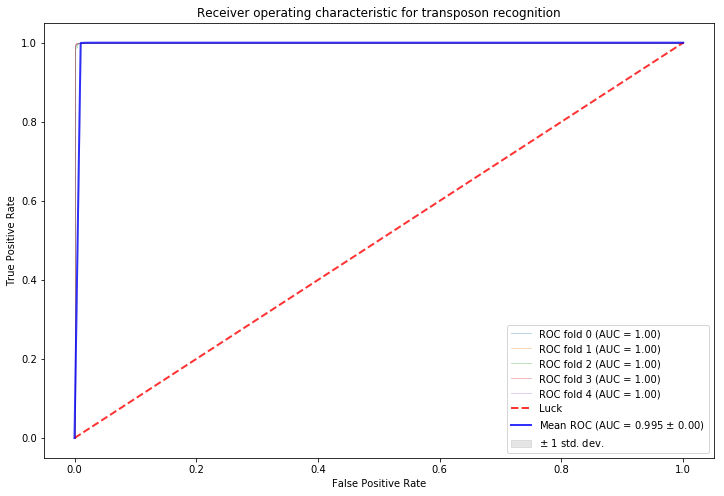

[('AG', 0.08236978966415255),
 ('RS2Slide (RNA)', 0.05942885174853907),
 ('LS2Slide (RNA)', 0.04737194586345402),
 ('RS2Rise (RNA)', 0.04609723971388124),
 ('GG', 0.04180365801403933),
 ('GA', 0.0387414036397256),
 ('RS2Shift (RNA)', 0.03762410638846305),
 ('TC', 0.036590591280010056),
 ('LS2Rise (RNA)', 0.03502262825357741),
 ('LS2Roll (RNA)', 0.03321829455845707),
 ('LS2Shift (RNA)', 0.029239269687358977),
 ('TG', 0.02535933867834125),
 ('CTC', 0.02438544973408881),
 ('RS2Enthalpy (RNA)', 0.022288887443364772),
 ('GAG', 0.02071386822064211),
 ('RS0Hydrophilicity (RNA)', 0.016933494408162733),
 ('LS2Hydrophilicity (RNA)', 0.016771939252569344),
 ('RS2Hydrophilicity (RNA)', 0.014457058994255595),
 ('RS2Tilt (RNA)', 0.013841512148752514),
 ('RS2Roll (RNA)', 0.013639626179707027)]

In [12]:
draw_roc_auc(dfX, dfY, rf)
list(sorted(zip(dfX.columns, rf.feature_importances_), key=lambda x:x[1], reverse=True))[:20]

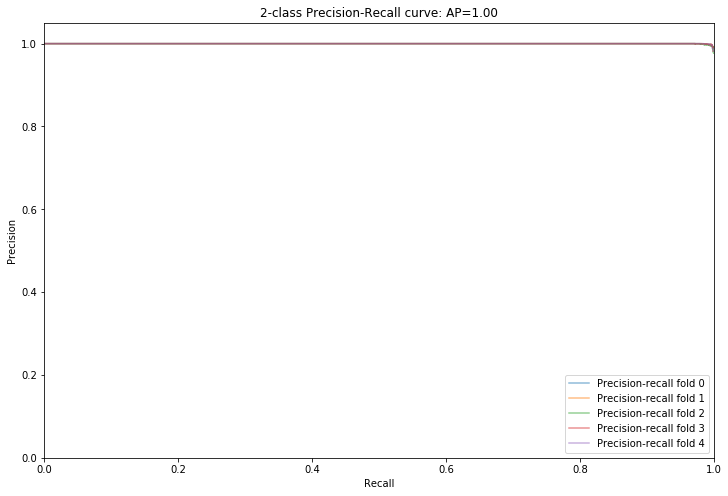

Precision:  0.999948264722857  Recall:  0.9994382024226335  Accuracy:  0.9920750732365177


In [13]:
draw_precision_recall(dfX, dfY, rf)

In [14]:
df2 = df[
    [col for col in list(df.columns) if col.startswith('LP') or
     col.startswith('LB') or
     col.startswith('RB') or
     col.startswith('LS') or
     col.startswith('RS') or
     col.startswith('GC p') or
     col == 'is_target'
    ]
]

In [15]:
df2.head()

,GC precentage,LB0A,LB0C,LB0G,LB0T,LB1A,LB1C,LB1G,LB1T,LB2A,...,RS8Entropy (RNA),RS8Free energy (RNA),RS8Hydrophilicity (RNA),RS8Rise (RNA),RS8Roll (RNA),RS8Shift (RNA),RS8Slide (RNA),RS8Tilt (RNA),RS8Twist (RNA),is_target
0,50.000000,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
1,32.000000,0,0,1,0,0,1,0,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
2,36.000000,0,0,1,0,0,0,0,1,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,0
3,50.000000,1,0,0,0,0,0,1,0,1,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1
4,52.173913,0,0,1,0,1,0,0,0,0,...,-27.8875,-2.134375,0.265,3.2525,8.5,0.053125,-1.523125,0.4375,31.4375,1


In [16]:
df2X = df2[[i for i in list(df2.columns) if i not in ('is_target')]]
df2Y = df2['is_target']

In [17]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=5)


In [18]:
# Results WITHOUT Di-Trinucleotides count features

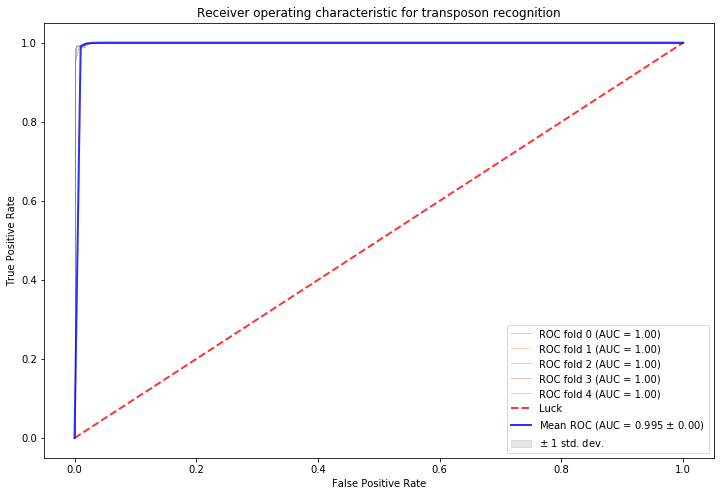

[('LS2Slide (RNA)', 0.06878041751850598),
 ('RS2Slide (RNA)', 0.059723990035904465),
 ('RS2Entropy (RNA)', 0.05795110592786025),
 ('RS2Rise (RNA)', 0.055926657658461484),
 ('RS2Shift (RNA)', 0.042881024893687),
 ('RS0Hydrophilicity (RNA)', 0.03943837738843491),
 ('RS2Enthalpy (RNA)', 0.03536364424117504),
 ('LS0Hydrophilicity (RNA)', 0.0333266745905013),
 ('LS2Roll (RNA)', 0.03276562233252509),
 ('LS2Hydrophilicity (RNA)', 0.03224558067781349),
 ('LS2Shift (RNA)', 0.029690562338411136),
 ('RS2Roll (RNA)', 0.028471333770602073),
 ('RS2Tilt (RNA)', 0.027814837379703382),
 ('LS0Tilt (RNA)', 0.026967260947392657),
 ('RB0C', 0.019463950183735507),
 ('LB0G', 0.018655679168934732),
 ('LB1C', 0.018524293562796022),
 ('RS2Twist (RNA)', 0.01775541010954699),
 ('LS2Rise (RNA)', 0.014622131348753658),
 ('LS2Tilt (RNA)', 0.014218099236742499)]

In [19]:
draw_roc_auc(df2X, df2Y, rf2)

list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
# top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x: x[1], reverse=True))
# top_features

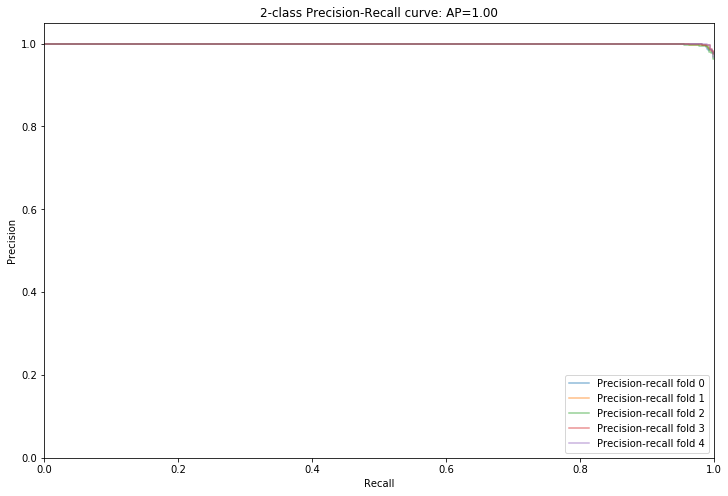

Precision:  0.999745272669521  Recall:  0.9983926516973003  Accuracy:  0.9892590702664352


In [20]:
draw_precision_recall(df2X, df2Y, rf2)

In [21]:
top_features = list(sorted(zip(df2X.columns, rf2.feature_importances_), key=lambda x:x[1], reverse=True))[:20]
pd.DataFrame(
    columns=df2X.columns, data=[
        df2X[df2Y==1].mean(),
        df2X[df2Y==0].mean(),
        df2X[df2Y==1].std(),
        df2X[df2Y==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0], top_features)))[:20]]

,RS2Tilt (RNA),RS2Shift (RNA),RS2Slide (RNA),LS2Rise (RNA),RS2Rise (RNA),LS2Roll (RNA),RS0Tilt (RNA),RS2Entropy (RNA),RB0C,LS2Slide (RNA),LS2Shift (RNA),LS2Tilt (RNA),RS2Hydrophilicity (RNA),LS0Hydrophilicity (RNA),LS2Enthalpy (RNA),RS0Rise (RNA),LP0G,RS2Roll (RNA),LS2Entropy (RNA),RB2T
Mean t,0.46,0.05,-1.53,3.26,3.26,8.50,1.01,-27.97,0.15,-1.53,0.05,0.50,0.29,0.13,-10.99,3.34,0.07,8.58,-28.40,0.10
Mean f,0.93,0.11,-1.46,3.23,3.11,5.47,0.44,-27.14,0.93,-1.44,0.21,0.77,0.33,0.26,-11.28,3.25,0.83,9.47,-29.18,0.91
Std t,0.19,0.05,0.06,0.04,0.03,0.62,0.41,1.00,0.36,0.06,0.03,0.24,0.08,0.08,0.75,0.06,0.26,0.68,1.79,0.30
Std f,0.17,0.03,0.02,0.04,0.06,1.56,0.07,0.67,0.25,0.03,0.06,0.13,0.03,0.02,0.30,0.02,0.37,1.22,0.80,0.29
